tb - 7/7/2022 - HP search for NNs taking specific humidity as inputs for online runs. Adapted from scripts from Sungduk Yu and Jerry Lin.

# Imports and initialization

In [1]:
import cftime
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pylab as plb
import matplotlib.image as imag

from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
#import tensorflow_addons as tfa
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 2
siz = 100

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = lw
plt.rc('font',size=fz)

In [3]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/June2022_CI_Runs/'
path_repeat = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/June2022_CI_Runs/specificNN_m4k_repeat//spehum_version_0_False/'
path_Jerry = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/AdaptedPreprocessing/Jerry_Bridges/'
path_J_h5 = ['specifich5/spehum','relativeh5/relhum']
path_J_norm = ['specific64/','relative64/']
path_J_loss = ['/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/specificHistory.txt',
              '/fast/jerryl9/pythonNotebooks/forTom/AdaptedPreprocessing/relativeHistory.txt']
path_div = [path_Jerry+path_J_norm[0]+'inp_div_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_div_Relative64.txt']
path_sub = [path_Jerry+path_J_norm[0]+'inp_sub_Specific64.txt',
           path_Jerry+path_J_norm[1]+'inp_sub_Relative64.txt']
path_out = [path_Jerry+path_J_norm[0]+'out_scale_Specific64.txt',
            path_Jerry+path_J_norm[1]+'out_scale_Relative64.txt']
path_txt = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/TXT_DATA/'
path_sub_tom = path_txt + 'inp_sub_Specificm4K.txt'
path_div_tom = path_txt + 'inp_div_Specificm4K.txt'
path_out_tom = path_txt + 'out_scale_Specificm4K.txt'

In [4]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']
path_Tom = ['/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_04_26_NN.hdf5',
            '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/2021_06_13_NN_RH.hdf5']
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
scale_dict_RH = scale_dict.copy()
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%
path_train_RH = path_data + '2021_01_24_O3_small_shuffle.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_train_BMSE = path_data + '2021_06_16_BMSE_small_shuffle.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
path_train_LHF_nsDELQ = path_data + '2021_02_01_O3_LHF_nsQ_small_shuffle.nc'
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
path_1year = path_data + '2022_08_01_TRAIN_M4K_First_Year.nc'
path_8months = path_data + '2022_08_01_TRAIN_M4K_First_Eight_Months.nc'
path_RH = [path_data+'2022_08_03_TRAIN_For_Jerry_RH_m4K.nc',path_data+'2022_08_03_VALID_For_Jerry_RH_m4K.nc']

In [5]:
path_Q = '/DFS-L/DATA/pritchard/jerryl9/forTom/specific64/'

# Build models and load data/models

## Load existing models

In [6]:
# with open(trainingPath + 'trainInput_Specific64.npy', 'rb') as f:
#     nnInput = np.load(f)

# with open(trainingPath + 'trainOutput_Specific64.npy', 'rb') as f:
#     nnOutput = np.load(f)

# with open(trainingPath + 'testInput_Specific64.npy', 'rb') as f:
#     valInput = np.load(f)

# with open(trainingPath + 'testOutput_Specific64.npy', 'rb') as f:
#     valOutput = np.load(f)

In [7]:
Inp_name = ['Q','RH']

MODELJ = {}

for iinput,inp in enumerate(path_J_h5):
    MODELJ[Inp_name[iinput]] = {}
    for dropout in range(5):
        MODELJ[Inp_name[iinput]][dropout] = {}
        for BN in (['True','False']):
            MODELJ[Inp_name[iinput]][dropout][BN] = \
            load_model(path_Jerry+inp+'_version_'+str(dropout)+'_'+BN+'.h5',compile=False)

In [8]:
## Load normalization and loss files for Jerry's case

SUB = {}; DIV = {}; OUT = {}

for iinp in range(2):
    DIV[iinp] = (pd.read_csv(path_div[iinp], sep=" ", header=None).values)[:,0]
    SUB[iinp] = (pd.read_csv(path_sub[iinp], sep=" ", header=None).values)[:,0]
    OUT[iinp] = (pd.read_csv(path_out[iinp], sep=" ", header=None).values)[:,0]

In [9]:
DIVT = (pd.read_csv(path_div_tom, sep=" ", header=None).values)[:,0]
SUBT = (pd.read_csv(path_sub_tom, sep=" ", header=None).values)[:,0]
OUTT = (pd.read_csv(path_out_tom, sep=" ", header=None).values)[:,0]

## Create new norm file from updated statistics

In [10]:
path_norm = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/2022_07_22_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

In [11]:
path_Rasp_norm = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/001_norm.nc'

In [41]:
newnorm = pkl.load(open(path_norm,'rb'))

In [42]:
Raspnorm = xr.open_dataset(path_Rasp_norm)

In [43]:
tomnorm = xr.open_dataset(path_input_norm)

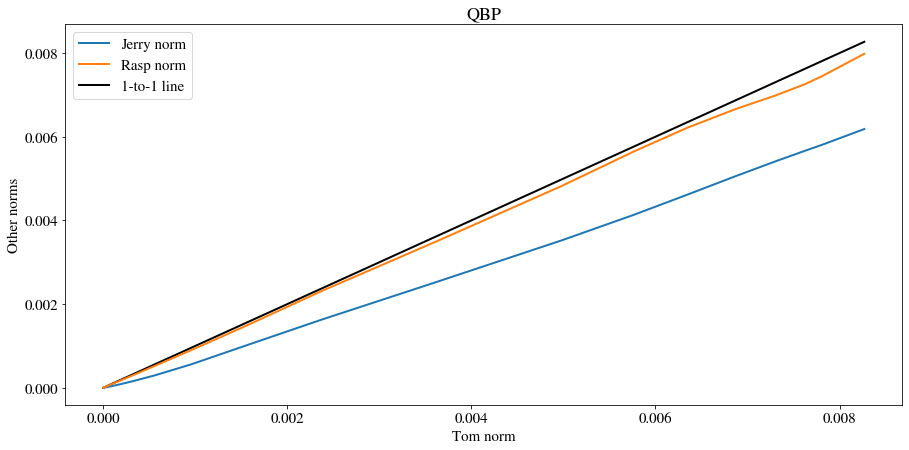

In [16]:
fig,ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(tomnorm['mean'][:30].values,SUB[0][30:60],label='Jerry norm')
plt.plot(tomnorm['mean'][:30].values,Raspnorm['mean'][:30].values,label='Rasp norm')
plt.plot(tomnorm['mean'][:30].values,tomnorm['mean'][:30].values,color='k',zorder=0,label='1-to-1 line')
plt.xlabel('Tom norm')
plt.ylabel('Other norms')
plt.title('QBP')
plt.legend()

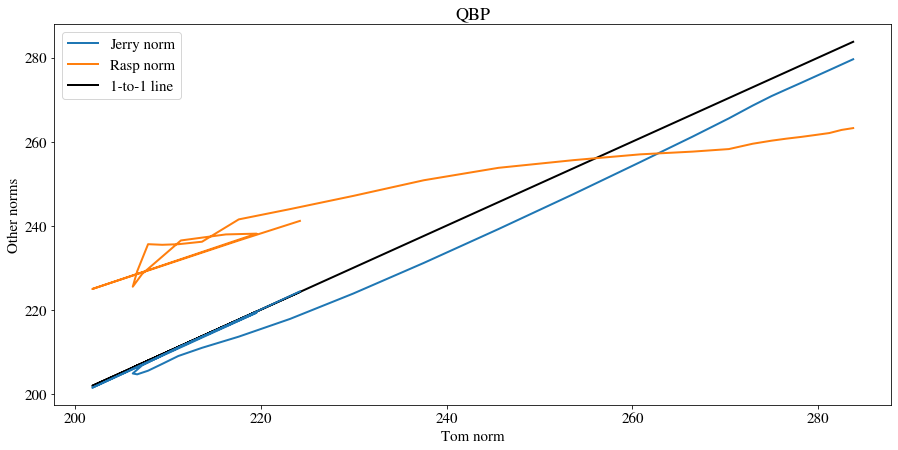

In [17]:
fig,ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(tomnorm['mean'][30:60].values,SUB[0][:30],label='Jerry norm')
plt.plot(tomnorm['mean'][30:60].values,Raspnorm['mean'][90:120].values,label='Rasp norm')
plt.plot(tomnorm['mean'][30:60].values,tomnorm['mean'][30:60].values,color='k',zorder=0,label='1-to-1 line')
plt.xlabel('Tom norm')
plt.ylabel('Other norms')
plt.title('QBP')
plt.legend()

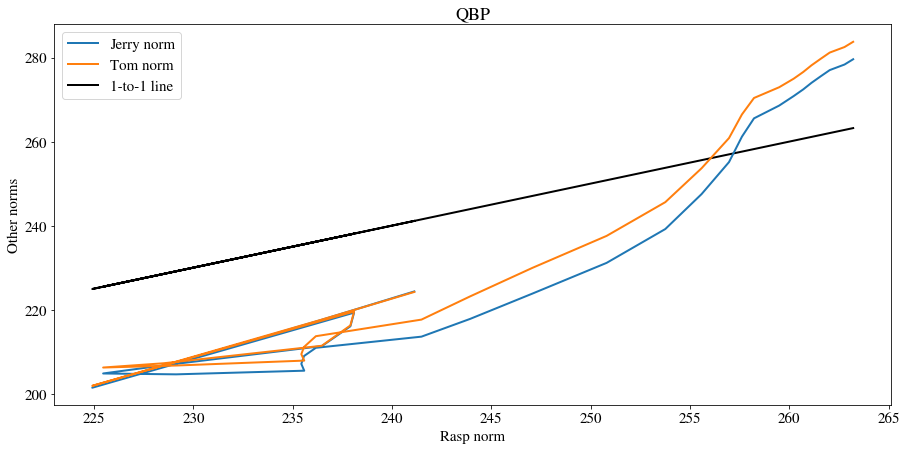

In [18]:
fig,ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(Raspnorm['mean'][90:120].values,SUB[0][:30],label='Jerry norm')
plt.plot(Raspnorm['mean'][90:120].values,tomnorm['mean'][30:60].values,label='Tom norm')
plt.plot(Raspnorm['mean'][90:120].values,Raspnorm['mean'][90:120].values,color='k',zorder=0,label='1-to-1 line')
plt.xlabel('Rasp norm')
plt.ylabel('Other norms')
plt.title('QBP')
plt.legend()

In [19]:
scale_dict['TPHYSTND']

array([ 28444.723,  52518.43 ,  86030.96 , 124105.82 , 155706.95 ,
       178836.6  , 178036.75 , 145884.84 , 171625.78 , 201908.83 ,
       237535.56 , 279448.   , 328756.1  , 386764.75 , 455008.78 ,
       535293.9  , 629745.9  , 740863.2  , 871587.25 , 871936.2  ,
       800265.7  , 675320.9  , 501908.4  , 290571.1  , 272605.56 ,
       252434.92 , 230183.3  , 205989.11 , 180040.48 , 152525.48 ],
      dtype=float32)

## For now use Tom norm as it is "smoother" than Stephan's norm & for consistency with the climate-invariant manuscript

Save Tom's norm in Jerry file format

### Initialization

In [23]:
SUBTOM = np.copy(SUB[0])
DIVTOM = np.copy(DIV[0])
OUTTOM = np.copy(OUT[0])

SUBRH = np.copy(SUB[0])
DIVRH = np.copy(DIV[0])
OUTRH = np.copy(OUT[0])

### Define generators

Careful for div because of the max ( std_by_var , max-min ) implemented by Stephan in the "normalization" cbrain script. As a precaution measure, I'll just copy paste what comes out of the input transformer

In [24]:
def train_gen_rescaling(input_rescaling,path_norm,path_train,scale_dict):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = ['TPHYSTND','PHQ'],
        norm_fn = path_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [25]:
train_gen_norm = train_gen_rescaling(['TBP','QBP','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                    path_input_norm,path_array['cold'][0],scale_dict)

In [26]:
train_gen_RH = train_gen_rescaling(['TBP','RH','PS', 'SOLIN', 'SHFLX', 'LHFLX'],
                                    path_norm_RH,path_array['cold'][0],scale_dict)

### Extract and save norm for Q network

In [27]:
sub = train_gen_norm.input_transform.sub
div = train_gen_norm.input_transform.div
subQ = sub[30:60]; divQ = div[30:60]
subT = sub[:30]; divT = div[:30]
subPS = sub[60]; divPS = div[60]
subS0 = sub[61]; divS0 = div[61]
subSHF = sub[62]; divSHF = div[62]
subLHF = sub[63]; divLHF = div[63]

In [28]:
# for i in range(30):
#     SUBTOM[i] = tomnorm['mean'][30+i].values
#     DIVTOM[i] = tomnorm['max'][30+i].values - tomnorm['min'][30+i].values
#     OUTTOM[i] = scale_dict['TPHYSTND'][i]
# for i in np.arange(30,60):
#     SUBTOM[i] = tomnorm['mean'][i-30].values
#     DIVTOM[i] = tomnorm['max'][i-30].values - tomnorm['min'][i-30].values
#     OUTTOM[i] = scale_dict['PHQ'][i-30]
# for i in np.arange(60,64):
#     SUBTOM[i] = tomnorm['mean'][30+i].values
#     DIVTOM[i] = tomnorm['max'][30+i].values - tomnorm['min'][30+i].values
for i in range(30): 
    SUBTOM[i] = subT[i]; 
    DIVTOM[i] = divT[i]; 
    OUTTOM[i] = scale_dict['TPHYSTND'][i]
for i in np.arange(30,60): 
    SUBTOM[i] = subQ[i-30]; 
    DIVTOM[i] = divQ[i-30]; 
    OUTTOM[i] = scale_dict['PHQ'][i-30]
for i in np.arange(60,64): 
    SUBTOM[i] = sub[i]; DIVTOM[i] = div[i]

In [49]:
path_txt = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/TXT_DATA/'
path_sub = path_txt + 'inp_sub_Specificm4K.txt'
path_div = path_txt + 'inp_div_Specificm4K.txt'
path_out = path_txt + 'out_scale_Specificm4K.txt'

In [50]:
# with open(path_sub, 'w') as f:
#     for i in range(64):
#         f.write('%01.18e'%SUBTOM[i]+'\n')

In [51]:
# with open(path_div, 'w') as f:
#     for i in range(64):
#         f.write('%01.18e'%DIVTOM[i]+'\n')

In [52]:
# with open(path_out, 'w') as f:
#     for i in range(60):
#         f.write('%01.18e'%OUTTOM[i]+'\n')

In [53]:
DIVT = (pd.read_csv(path_div, sep=" ", header=None).values)[:,0]
SUBT = (pd.read_csv(path_sub, sep=" ", header=None).values)[:,0]
OUTT = (pd.read_csv(path_out, sep=" ", header=None).values)[:,0]

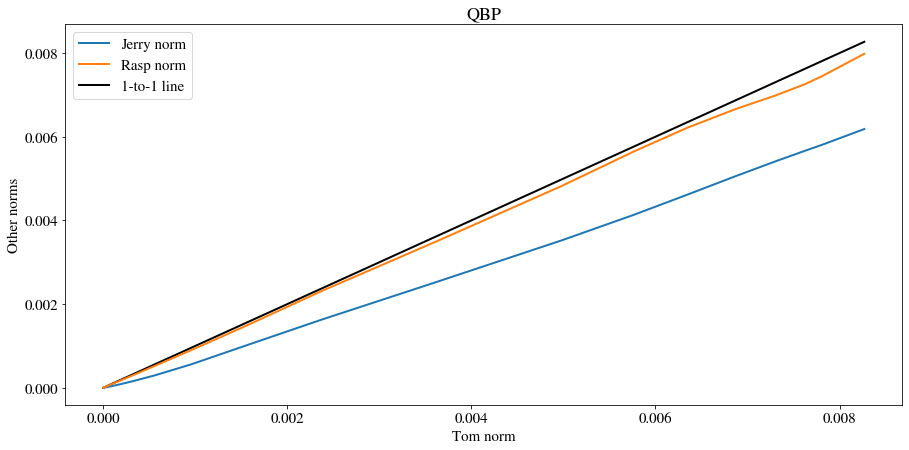

In [54]:
fig,ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(SUBT[30:60],SUB[0][30:60],label='Jerry norm')
plt.plot(SUBT[30:60],Raspnorm['mean'][:30].values,label='Rasp norm')
plt.plot(SUBT[30:60],tomnorm['mean'][:30].values,color='k',zorder=0,label='1-to-1 line')
plt.xlabel('Tom norm')
plt.ylabel('Other norms')
plt.title('QBP')
plt.legend()

### Extract and save norm for RH network

In [33]:
sub = train_gen_RH.input_transform.sub
div = train_gen_RH.input_transform.div
subQ = sub[30:60]; divQ = div[30:60]
subT = sub[:30]; divT = div[:30]
subPS = sub[60]; divPS = div[60]
subS0 = sub[61]; divS0 = div[61]
subSHF = sub[62]; divSHF = div[62]
subLHF = sub[63]; divLHF = div[63]

In [34]:
subQ

array([0.08771713, 0.14805274, 0.14172984, 0.06804938, 0.06643728,
       0.07139269, 0.1583852 , 0.23619738, 0.21669908, 0.23235418,
       0.28699058, 0.35586399, 0.42467885, 0.4722922 , 0.50655441,
       0.54865186, 0.57714915, 0.5890316 , 0.58418539, 0.58264578,
       0.61462287, 0.7056973 , 0.83321016, 0.88314484, 0.90395834,
       0.90671017, 0.89410756, 0.86893327, 0.83477947, 0.83341838])

In [35]:
for i in range(30): 
    SUBRH[i] = subT[i]; 
    DIVRH[i] = divT[i]; 
    OUTRH[i] = scale_dict['TPHYSTND'][i]
for i in np.arange(30,60): 
    SUBRH[i] = subQ[i-30]; 
    DIVRH[i] = divQ[i-30]; 
    OUTRH[i] = scale_dict['PHQ'][i-30]
for i in np.arange(60,64): 
    SUBRH[i] = sub[i]; DIVRH[i] = div[i]

In [36]:
path_txt = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/TXT_DATA/'
path_sub = path_txt + 'inp_sub_Relativem4K.txt'
path_div = path_txt + 'inp_div_Relativem4K.txt'
path_out = path_txt + 'out_scale_Relativem4K.txt'

In [37]:
with open(path_sub, 'w') as f:
    for i in range(64):
        f.write('%01.18e'%SUBRH[i]+'\n')

with open(path_div, 'w') as f:
    for i in range(64):
        f.write('%01.18e'%DIVRH[i]+'\n')

with open(path_out, 'w') as f:
    for i in range(60):
        f.write('%01.18e'%OUTRH[i]+'\n')

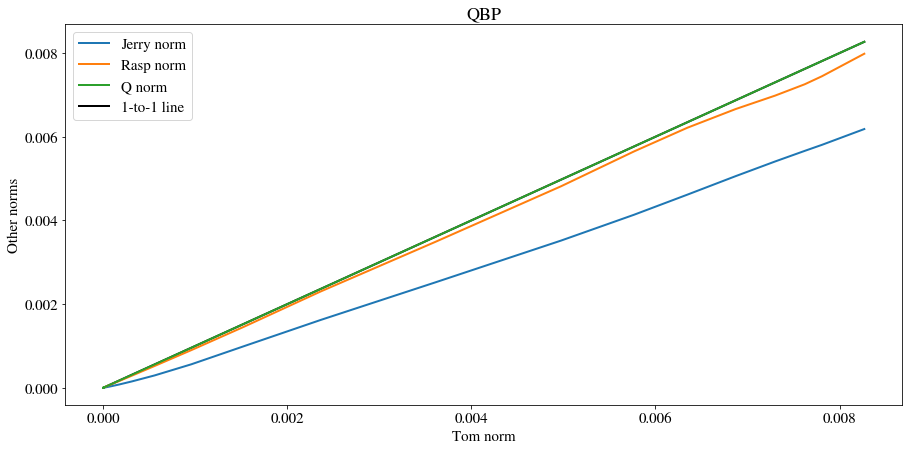

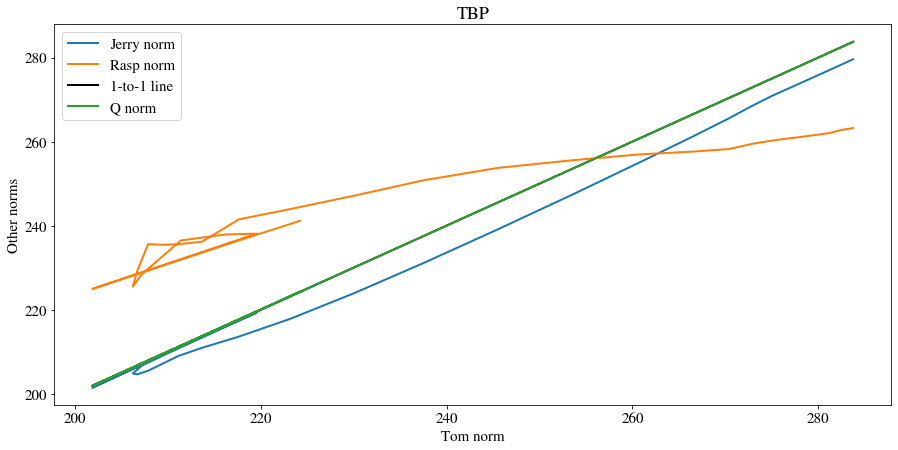

In [55]:
DIVT2 = (pd.read_csv(path_div, sep=" ", header=None).values)[:,0]
SUBT2 = (pd.read_csv(path_sub, sep=" ", header=None).values)[:,0]
OUTT2 = (pd.read_csv(path_out, sep=" ", header=None).values)[:,0]

fig,ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(SUBT2[30:60],SUB[0][30:60],label='Jerry norm')
plt.plot(SUBT2[30:60],Raspnorm['mean'][:30].values,label='Rasp norm')
plt.plot(SUBT2[30:60],SUBT[30:60],label='Q norm')
plt.plot(SUBT2[30:60],tomnorm['mean'][:30].values,color='k',zorder=0,label='1-to-1 line')
plt.xlabel('Tom norm')
plt.ylabel('Other norms')
plt.title('QBP')
plt.legend()

fig,ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(SUBT2[:30],SUB[0][:30],label='Jerry norm')
plt.plot(SUBT2[:30],Raspnorm['mean'][90:120].values,label='Rasp norm')
plt.plot(SUBT2[:30],tomnorm['mean'][30:60].values,color='k',zorder=0,label='1-to-1 line')
plt.plot(SUBT2[:30],SUBT[:30],label='Q norm')
plt.xlabel('Tom norm')
plt.ylabel('Other norms')
plt.title('TBP')
plt.legend()

# Training Q-models

## Standard brute-force training from the climate-invariant paper

In [11]:
in_vars = ['TBP','QBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['TPHYSTND','PHQ'] # and we output the response of clouds/storms to these climate conditions

In [12]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['TBP','QBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['TPHYSTND','PHQ'] # and we output the response of clouds/storms to these climate conditionspath_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [14]:
BFgen = {}
#CIgen = {}

for iclimate,clim in enumerate(['cold','hot']):
    print('Climate = ',clim)
    BFgen[clim] = {}
#    CIgen[clim] = {}
    
    for iset,st in enumerate(['train','valid','test']):
        print('Set = ',st)
        
        BFgen[clim][st] = Generator_singleDS(path_array[clim][iset])
#        CIgen[clim][st] = Generator_singleDS(path_array[clim][iset],rescaling='CI')

Climate =  cold
Set =  train
Set =  valid
Set =  test
Climate =  hot
Set =  train
Set =  valid
Set =  test


In [15]:
def NN_model(inp,N_layer):
    if N_layer>0:
        densout = Dense(128, activation='linear')(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(120, activation='linear')(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(60, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [10]:
inpBF = Input(shape=(64,)) ## input 
NN_BF = NN_model(inpBF,7)

In [11]:
NN_BF.compile(tf.keras.optimizers.Adam(), loss=mse)

In [16]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
new_save_name = '2022_07_30_NN_BF_m4K'
save_name = '2022_07_25_NN_BF_m4K'

In [13]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+new_save_name+'_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [14]:
NN_BF.load_weights(path_HDF5+save_name+'_BF.hdf5')

In [50]:
Nep = 20

In [51]:
# NN_BF.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
#                      callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
5759/5759 [==============================] - 1392s 242ms/step - loss: 409.3990 - val_loss: 385.6279
Epoch 2/20
5759/5759 [==============================] - 544s 94ms/step - loss: 375.3134 - val_loss: 368.5188
Epoch 3/20
5759/5759 [==============================] - 542s 94ms/step - loss: 363.5546 - val_loss: 359.5259
Epoch 4/20
5759/5759 [==============================] - 543s 94ms/step - loss: 356.7032 - val_loss: 357.3547
Epoch 5/20
5759/5759 [==============================] - 562s 98ms/step - loss: 352.4467 - val_loss: 352.7780
Epoch 6/20
5759/5759 [==============================] - 561s 97ms/step - loss: 349.7054 - val_loss: 349.4039
Epoch 7/20
5759/5759 [==============================] - 556s 96ms/step - loss: 347.2613 - val_loss: 346.9410
Epoch 8/20
5759/5759 [==============================] - 561s 97ms/step - loss: 345.2908 - val_loss: 344.7684
Epoch 9/20
5759/5759 [==============================] - 553s 96ms/step - loss: 343.8586 - val_loss: 342.4345
Epoch 10/20
5759/

In [52]:
# NN_BF.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
#                      callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
5759/5759 [==============================] - 576s 100ms/step - loss: 335.5791 - val_loss: 337.4262
Epoch 2/20
5759/5759 [==============================] - 590s 102ms/step - loss: 335.2313 - val_loss: 337.5208
Epoch 3/20
5759/5759 [==============================] - 573s 100ms/step - loss: 334.8578 - val_loss: 336.2839
Epoch 4/20
5759/5759 [==============================] - 575s 100ms/step - loss: 334.5395 - val_loss: 334.6838
Epoch 5/20
5759/5759 [==============================] - 592s 103ms/step - loss: 334.1826 - val_loss: 334.7820
Epoch 6/20
5759/5759 [==============================] - 580s 101ms/step - loss: 333.8586 - val_loss: 334.8297
Epoch 7/20
5759/5759 [==============================] - 582s 101ms/step - loss: 333.6464 - val_loss: 335.0807
Epoch 8/20
5759/5759 [==============================] - 586s 102ms/step - loss: 333.3572 - val_loss: 335.1204
Epoch 9/20
5759/5759 [==============================] - 591s 103ms/step - loss: 333.1583 - val_loss: 333.9345
Epoch 10/2

In [53]:
# NN_BF.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
#                      callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
5759/5759 [==============================] - 540s 94ms/step - loss: 330.8930 - val_loss: 332.8144
Epoch 2/20
5759/5759 [==============================] - 597s 104ms/step - loss: 330.7885 - val_loss: 333.3497
Epoch 3/20
5759/5759 [==============================] - 605s 105ms/step - loss: 330.6589 - val_loss: 333.2262
Epoch 4/20
5759/5759 [==============================] - 591s 103ms/step - loss: 330.4752 - val_loss: 332.7113
Epoch 5/20
5759/5759 [==============================] - 594s 103ms/step - loss: 330.3567 - val_loss: 332.5110
Epoch 6/20
5759/5759 [==============================] - 576s 100ms/step - loss: 330.2597 - val_loss: 333.2440
Epoch 7/20
5759/5759 [==============================] - 602s 105ms/step - loss: 330.0780 - val_loss: 332.2010
Epoch 8/20
5759/5759 [==============================] - 607s 105ms/step - loss: 330.0397 - val_loss: 331.5011
Epoch 9/20
5759/5759 [==============================] - 631s 110ms/step - loss: 329.8889 - val_loss: 331.8976
Epoch 10/20

In [15]:
Nep = 60

In [16]:
NN_BF.fit_generator(BFgen['cold']['valid'], epochs=Nep, validation_data=BFgen['cold']['train'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/60
5903/5903 [==============================] - 1490s 252ms/step - loss: 331.1007 - val_loss: 328.7606
Epoch 2/60
5903/5903 [==============================] - 606s 103ms/step - loss: 330.5713 - val_loss: 328.7617
Epoch 3/60
5903/5903 [==============================] - 591s 100ms/step - loss: 330.3325 - val_loss: 329.8306
Epoch 4/60
5903/5903 [==============================] - 610s 103ms/step - loss: 330.1542 - val_loss: 331.0607
Epoch 5/60
5903/5903 [==============================] - 599s 101ms/step - loss: 330.0238 - val_loss: 329.6670
Epoch 6/60
5903/5903 [==============================] - 613s 104ms/step - loss: 329.8073 - val_loss: 329.6990
Epoch 7/60
5903/5903 [==============================] - 640s 108ms/step - loss: 329.6210 - val_loss: 331.6836
Epoch 8/60
5903/5903 [==============================] - 772s 131ms/step - loss: 329.4976 - val_loss: 330.3573
Epoch 9/60
5903/5903 [==============================] - 756s 128ms/step - loss: 329.4372 - val_loss: 329.2629
Epoch 10/

In [17]:
NN_BF.fit_generator(BFgen['cold']['valid'], epochs=Nep, validation_data=BFgen['cold']['train'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/60
5903/5903 [==============================] - 769s 130ms/step - loss: 329.0790 - val_loss: 329.4198
Epoch 2/60
5903/5903 [==============================] - 891s 151ms/step - loss: 328.9034 - val_loss: 330.2884
Epoch 3/60
5903/5903 [==============================] - 806s 137ms/step - loss: 328.8338 - val_loss: 328.5774
Epoch 4/60
5903/5903 [==============================] - 760s 129ms/step - loss: 328.7323 - val_loss: 331.2501
Epoch 5/60
5903/5903 [==============================] - 706s 120ms/step - loss: 328.5856 - val_loss: 329.0077
Epoch 6/60
5903/5903 [==============================] - 632s 107ms/step - loss: 328.4981 - val_loss: 330.6399
Epoch 7/60
5903/5903 [==============================] - 629s 106ms/step - loss: 328.4447 - val_loss: 328.1073
Epoch 8/60
5903/5903 [==============================] - 623s 106ms/step - loss: 328.4212 - val_loss: 329.9401
Epoch 9/60
5903/5903 [==============================] - 625s 106ms/step - loss: 328.2681 - val_loss: 331.4977
Epoch 10/6

## Strong L1 regularization

In [25]:
def NN_model(inp,N_layer,l1):
    if N_layer>0:
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l1(l1))(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l1(l1))(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l1(l1))(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l1(l1))(densout)
    return tf.keras.models.Model(inp, dense_out)

In [26]:
inpBF1 = Input(shape=(64,)) ## input 
NN_BF1 = NN_model(inpBF1,7,0.05)

In [27]:
NN_BF1.compile(tf.keras.optimizers.Adam(), loss=mse)

In [28]:
NN_BF1.load_weights(path_HDF5+save_name+'_BF.hdf5')

In [29]:
L1_save_name = '2022_07_30_NN_BF_m4K_L1'

In [30]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [31]:
NN_BF1.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 656s 114ms/step - loss: 672.2384 - val_loss: 489.3609
Epoch 2/40
5759/5759 [==============================] - 669s 116ms/step - loss: 466.5325 - val_loss: 452.8798
Epoch 3/40
5759/5759 [==============================] - 681s 118ms/step - loss: 445.0914 - val_loss: 439.2802
Epoch 4/40
5759/5759 [==============================] - 697s 121ms/step - loss: 435.3466 - val_loss: 432.8159
Epoch 5/40
5759/5759 [==============================] - 638s 111ms/step - loss: 429.7238 - val_loss: 427.9722
Epoch 6/40
5759/5759 [==============================] - 636s 110ms/step - loss: 425.9914 - val_loss: 424.4413
Epoch 7/40
5759/5759 [==============================] - 673s 117ms/step - loss: 423.1605 - val_loss: 421.4091
Epoch 8/40
5759/5759 [==============================] - 664s 115ms/step - loss: 420.7106 - val_loss: 420.2279
Epoch 9/40
5759/5759 [==============================] - 676s 117ms/step - loss: 418.7706 - val_loss: 418.7612
Epoch 10/4

## Standard L1 regularization

In [32]:
inpBF2 = Input(shape=(64,)) ## input 
NN_BF2 = NN_model(inpBF2,7,0.01)

NN_BF2.compile(tf.keras.optimizers.Adam(), loss=mse)

NN_BF2.load_weights(path_HDF5+save_name+'_BF.hdf5')

L1_save_name = '2022_07_30_NN_BF_m4K_L1_standard'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [33]:
NN_BF2.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 637s 111ms/step - loss: 484.8808 - val_loss: 429.4638
Epoch 2/40
5759/5759 [==============================] - 671s 117ms/step - loss: 414.6526 - val_loss: 405.8307
Epoch 3/40
5759/5759 [==============================] - 654s 114ms/step - loss: 398.8990 - val_loss: 395.6879
Epoch 4/40
5759/5759 [==============================] - 690s 120ms/step - loss: 391.6431 - val_loss: 389.9996
Epoch 5/40
5759/5759 [==============================] - 685s 119ms/step - loss: 387.3362 - val_loss: 386.2633
Epoch 6/40
5759/5759 [==============================] - 643s 112ms/step - loss: 384.2790 - val_loss: 382.9925
Epoch 7/40
5759/5759 [==============================] - 650s 113ms/step - loss: 382.0439 - val_loss: 381.2663
Epoch 8/40
5759/5759 [==============================] - 662s 115ms/step - loss: 380.4465 - val_loss: 380.5361
Epoch 9/40
5759/5759 [==============================] - 663s 115ms/step - loss: 379.0057 - val_loss: 377.6719
Epoch 10/4

## Strong L2 regularization

In [18]:
def NN_model(inp,N_layer,l2):
    if N_layer>0:
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l2(l2))(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l2(l2))(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l2(l2))(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l2(l2))(densout)
    return tf.keras.models.Model(inp, dense_out)

In [35]:
inpBF3 = Input(shape=(64,)) ## input 
NN_BF3 = NN_model(inpBF3,7,0.05)

In [36]:
NN_BF3.compile(tf.keras.optimizers.Adam(), loss=mse)

NN_BF3.load_weights(path_HDF5+save_name+'_BF.hdf5')

L1_save_name = '2022_07_30_NN_BF_m4K_L2'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [37]:
NN_BF3.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 664s 115ms/step - loss: 571.5430 - val_loss: 436.8997
Epoch 2/40
5759/5759 [==============================] - 676s 117ms/step - loss: 425.5671 - val_loss: 419.9709
Epoch 3/40
5759/5759 [==============================] - 651s 113ms/step - loss: 417.9136 - val_loss: 417.3352
Epoch 4/40
5759/5759 [==============================] - 671s 116ms/step - loss: 414.9601 - val_loss: 414.5021
Epoch 5/40
5759/5759 [==============================] - 677s 118ms/step - loss: 413.2705 - val_loss: 414.5687
Epoch 6/40
5759/5759 [==============================] - 703s 122ms/step - loss: 412.1243 - val_loss: 412.2416
Epoch 7/40
5759/5759 [==============================] - 718s 125ms/step - loss: 411.4218 - val_loss: 410.7336
Epoch 8/40
5759/5759 [==============================] - 680s 118ms/step - loss: 410.8829 - val_loss: 413.1913
Epoch 9/40
5759/5759 [==============================] - 675s 117ms/step - loss: 410.4949 - val_loss: 412.9937
Epoch 10/4

## Standard L2 regularization

In [19]:
inpBF4 = Input(shape=(64,)) ## input 
NN_BF4 = NN_model(inpBF4,7,0.01)

NN_BF4.compile(tf.keras.optimizers.Adam(), loss=mse)

NN_BF4.load_weights(path_HDF5+save_name+'_BF.hdf5')

L1_save_name = '2022_07_30_NN_BF_m4K_L2_standard'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [20]:
NN_BF4.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 1471s 255ms/step - loss: 413.6964 - val_loss: 381.2285
Epoch 2/40
5759/5759 [==============================] - 605s 105ms/step - loss: 373.7400 - val_loss: 372.4575
Epoch 3/40
5759/5759 [==============================] - 620s 108ms/step - loss: 368.1371 - val_loss: 366.6831
Epoch 4/40
5759/5759 [==============================] - 618s 107ms/step - loss: 365.8842 - val_loss: 366.6101
Epoch 5/40
5759/5759 [==============================] - 654s 114ms/step - loss: 364.7095 - val_loss: 366.6077
Epoch 6/40
5759/5759 [==============================] - 671s 116ms/step - loss: 363.9781 - val_loss: 365.5680
Epoch 7/40
5759/5759 [==============================] - 645s 112ms/step - loss: 363.4607 - val_loss: 364.2105
Epoch 8/40
5759/5759 [==============================] - 629s 109ms/step - loss: 363.0436 - val_loss: 364.4343
Epoch 9/40
5759/5759 [==============================] - 651s 113ms/step - loss: 362.8049 - val_loss: 362.9268
Epoch 10/

In [21]:
NN_BF4.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 763s 133ms/step - loss: 360.5593 - val_loss: 361.6474
Epoch 2/40
5759/5759 [==============================] - 784s 136ms/step - loss: 360.5326 - val_loss: 364.7338
Epoch 3/40
5759/5759 [==============================] - 756s 131ms/step - loss: 360.4914 - val_loss: 362.5611
Epoch 4/40
5759/5759 [==============================] - 708s 123ms/step - loss: 360.4814 - val_loss: 362.9025
Epoch 5/40
5759/5759 [==============================] - 623s 108ms/step - loss: 360.4415 - val_loss: 361.0159
Epoch 6/40
5759/5759 [==============================] - 674s 117ms/step - loss: 360.3913 - val_loss: 361.7176
Epoch 7/40
5759/5759 [==============================] - 718s 125ms/step - loss: 360.3558 - val_loss: 359.8694
Epoch 8/40
5759/5759 [==============================] - 677s 118ms/step - loss: 360.3469 - val_loss: 362.2639
Epoch 9/40
5759/5759 [==============================] - 739s 128ms/step - loss: 360.3356 - val_loss: 360.3508
Epoch 10/4

## Cyclic learning rate

Code directly copied from source [https://github.com/tensorflow/addons/blob/v0.17.0/tensorflow_addons/optimizers/cyclical_learning_rate.py#L24-L111] and [https://github.com/tensorflow/addons/blob/b2dafcfa74c5de268b8a5c53813bc0b89cadf386/tensorflow_addons/utils/types.py#L61]

In [23]:
from typeguard import typechecked
from typing import Union, Callable
FloatTensorLike = Union[tf.Tensor, float, np.float16, np.float32, np.float64]

In [24]:
class CyclicalLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule that uses cyclical schedule."""

    @typechecked
    def __init__(
        self,
        initial_learning_rate: Union[FloatTensorLike, Callable],
        maximal_learning_rate: Union[FloatTensorLike, Callable],
        step_size: FloatTensorLike,
        scale_fn: Callable,
        scale_mode: str = "cycle",
        name: str = "CyclicalLearningRate",
    ):
        """Applies cyclical schedule to the learning rate.
        See Cyclical Learning Rates for Training Neural Networks. https://arxiv.org/abs/1506.01186
        ```python
        lr_schedule = tf.keras.optimizers.schedules.CyclicalLearningRate(
            initial_learning_rate=1e-4,
            maximal_learning_rate=1e-2,
            step_size=2000,
            scale_fn=lambda x: 1.,
            scale_mode="cycle",
            name="MyCyclicScheduler")
        model.compile(optimizer=tf.keras.optimizers.SGD(
                                                    learning_rate=lr_schedule),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(data, labels, epochs=5)
        ```
        You can pass this schedule directly into a
        `tf.keras.optimizers.Optimizer` as the learning rate.
        Args:
            initial_learning_rate: A scalar `float32` or `float64` `Tensor` or
                a Python number.  The initial learning rate.
            maximal_learning_rate: A scalar `float32` or `float64` `Tensor` or
                a Python number.  The maximum learning rate.
            step_size: A scalar `float32` or `float64` `Tensor` or a
                Python number. Step size denotes the number of training iterations it takes to get to maximal_learning_rate.
            scale_fn: A function. Scheduling function applied in cycle
            scale_mode: ['cycle', 'iterations']. Mode to apply during cyclic
                schedule
            name: (Optional) Name for the operation.
        Returns:
            Updated learning rate value.
        """
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.maximal_learning_rate = maximal_learning_rate
        self.step_size = step_size
        self.scale_fn = scale_fn
        self.scale_mode = scale_mode
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "CyclicalLearningRate"):
            initial_learning_rate = tf.convert_to_tensor(
                self.initial_learning_rate, name="initial_learning_rate"
            )
            dtype = initial_learning_rate.dtype
            maximal_learning_rate = tf.cast(self.maximal_learning_rate, dtype)
            step_size = tf.cast(self.step_size, dtype)
            step_as_dtype = tf.cast(step, dtype)
            cycle = tf.floor(1 + step_as_dtype / (2 * step_size))
            x = tf.abs(step_as_dtype / step_size - 2 * cycle + 1)

            mode_step = cycle if self.scale_mode == "cycle" else step

            return initial_learning_rate + (
                maximal_learning_rate - initial_learning_rate
            ) * tf.maximum(tf.cast(0, dtype), (1 - x)) * self.scale_fn(mode_step)

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "maximal_learning_rate": self.maximal_learning_rate,
            "scale_fn": self.scale_fn,
            "step_size": self.step_size,
            "scale_mode": self.scale_mode,
        }

In [ ]:
INIT_LR = 1e-4
MAX_LR = 1e-2
steps_per_epoch = x_train.shape[0] // BATCH_SIZE
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
                                          maximal_learning_rate=MAX_LR,
                                          scale_fn=lambda x: 1/(2.**(x-1)),
                                          step_size=2 * steps_per_epoch,
                                          scale_mode = 'cycle'
                                         )

In [46]:
inpBF2 = Input(shape=(64,)) ## input 
NN_BF_CLR = NN_model(inpBF2,7)

In [47]:
NN_BF_CLR.compile(tf.optimizers.Adam(learning_rate=clr), loss=mse)

In [48]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_07_25_NN_BF_CLR_m4K'

In [49]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+save_name+'_BF.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [50]:
Nep = 20

In [ ]:
# NN_BF.fit_generator(BFgen['cold']['train'], epochs=Nep, validation_data=BFgen['cold']['valid'],
#                      callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
1652/5759 [=======>......................] - ETA: 13:16 - loss: 447.5775

# Training RH models

## Standard brute-force training from the climate-invariant paper

In [12]:
in_vars = ['TBP','RH','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['TPHYSTND','PHQ'] # and we output the response of clouds/storms to these climate conditions

In [13]:
def Generator_singleDS(path,rescaling=None):
    
    in_vars = ['TBP','RH','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
    out_vars = ['TPHYSTND','PHQ'] # and we output the response of clouds/storms to these climate conditionspath_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
    scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))
    
    if rescaling=='CI':
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_norm_RH,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        Qscaling = 'RH',
        Tscaling = 'BMSE',
        LHFscaling = 'LHF_nsDELQ',
        hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
        inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
        inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
        inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
        inp_div_Tscaling=train_gen_BMSE.input_transform.div,
        inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
        inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
        ) 
    else:
        gen = DataGeneratorCI(
        data_fn = path,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = path_norm_RH,
        batch_size=8192,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict
        )

    return gen 

In [14]:
TrainRHgen = Generator_singleDS(path_RH[0])
ValidRHgen = Generator_singleDS(path_RH[1])

In [15]:
def NN_model(inp,N_layer):
    if N_layer>0:
        densout = Dense(128, activation='linear')(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(120, activation='linear')(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(60, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

In [16]:
inpBF = Input(shape=(64,)) ## input 
NN_BF = NN_model(inpBF,7)

In [17]:
NN_BF.compile(tf.keras.optimizers.Adam(), loss=mse)

In [18]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
#new_save_name = '2022_07_30_NN_BF_m4K'
save_name = '2022_08_03_NN_RH_m4K'

In [19]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [20]:
Nep = 20

In [77]:
# NN_BF.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
#                      callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
5759/5759 [==============================] - 574s 100ms/step - loss: 398.4601 - val_loss: 375.0955
Epoch 2/20
5759/5759 [==============================] - 572s 99ms/step - loss: 367.8252 - val_loss: 362.6394
Epoch 3/20
5759/5759 [==============================] - 519s 90ms/step - loss: 358.3485 - val_loss: 354.9930
Epoch 4/20
5759/5759 [==============================] - 551s 96ms/step - loss: 352.6859 - val_loss: 351.4554
Epoch 5/20
5759/5759 [==============================] - 544s 94ms/step - loss: 348.8698 - val_loss: 349.7747
Epoch 6/20
5759/5759 [==============================] - 520s 90ms/step - loss: 346.4972 - val_loss: 348.0287
Epoch 7/20
5759/5759 [==============================] - 472s 82ms/step - loss: 344.6449 - val_loss: 346.2910
Epoch 8/20
5759/5759 [==============================] - 494s 86ms/step - loss: 342.9058 - val_loss: 342.3957
Epoch 9/20
5759/5759 [==============================] - 511s 89ms/step - loss: 341.4252 - val_loss: 343.8559
Epoch 10/20
5759/5

In [78]:
NN_BF.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
5759/5759 [==============================] - 556s 97ms/step - loss: 333.4442 - val_loss: 336.6459
Epoch 2/20
5759/5759 [==============================] - 523s 91ms/step - loss: 333.1525 - val_loss: 333.9751
Epoch 3/20
5759/5759 [==============================] - 560s 97ms/step - loss: 332.8046 - val_loss: 332.7567
Epoch 4/20
5759/5759 [==============================] - 572s 99ms/step - loss: 332.5421 - val_loss: 334.1575
Epoch 5/20
5759/5759 [==============================] - 596s 103ms/step - loss: 332.1687 - val_loss: 332.9292
Epoch 6/20
5759/5759 [==============================] - 583s 101ms/step - loss: 331.9488 - val_loss: 333.9116
Epoch 7/20
5759/5759 [==============================] - 639s 111ms/step - loss: 331.6671 - val_loss: 332.5698
Epoch 8/20
5759/5759 [==============================] - 590s 102ms/step - loss: 331.4404 - val_loss: 332.4797
Epoch 9/20
5759/5759 [==============================] - 602s 105ms/step - loss: 331.2105 - val_loss: 332.3474
Epoch 10/20
57

In [79]:
NN_BF.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/20
5759/5759 [==============================] - 557s 97ms/step - loss: 329.1354 - val_loss: 330.8042
Epoch 2/20
5759/5759 [==============================] - 596s 104ms/step - loss: 329.0108 - val_loss: 331.8983
Epoch 3/20
5759/5759 [==============================] - 596s 103ms/step - loss: 328.8900 - val_loss: 331.5891
Epoch 4/20
5759/5759 [==============================] - 579s 101ms/step - loss: 328.7828 - val_loss: 330.7911
Epoch 5/20
5759/5759 [==============================] - 614s 107ms/step - loss: 328.7006 - val_loss: 330.3951
Epoch 6/20
5759/5759 [==============================] - 570s 99ms/step - loss: 328.5840 - val_loss: 331.5144
Epoch 7/20
5759/5759 [==============================] - 573s 100ms/step - loss: 328.4836 - val_loss: 329.1223
Epoch 8/20
5759/5759 [==============================] - 579s 101ms/step - loss: 328.3519 - val_loss: 330.8367
Epoch 9/20
5759/5759 [==============================] - 620s 108ms/step - loss: 328.2306 - val_loss: 330.3978
Epoch 10/20


## Strong L2 regularization

In [80]:
def NN_model(inp,N_layer,l2):
    if N_layer>0:
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l2(l2))(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l2(l2))(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l2(l2))(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l2(l2))(densout)
    return tf.keras.models.Model(inp, dense_out)

In [81]:
inpBF3 = Input(shape=(64,)) ## input 
NN_BF3 = NN_model(inpBF3,7,0.05)

In [82]:
NN_BF3.compile(tf.keras.optimizers.Adam(), loss=mse)

NN_BF3.load_weights(path_HDF5+save_name+'.hdf5')

L1_save_name = '2022_08_03_NN_RH_m4K_L2'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [83]:
NN_BF3.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 396s 69ms/step - loss: 492.9353 - val_loss: 426.8981
Epoch 2/40
5759/5759 [==============================] - 391s 68ms/step - loss: 419.1398 - val_loss: 415.5946
Epoch 3/40
5759/5759 [==============================] - 401s 70ms/step - loss: 412.3389 - val_loss: 411.1093
Epoch 4/40
5759/5759 [==============================] - 499s 87ms/step - loss: 409.4760 - val_loss: 409.3126
Epoch 5/40
5759/5759 [==============================] - 394s 68ms/step - loss: 407.8029 - val_loss: 408.4817
Epoch 6/40
5759/5759 [==============================] - 384s 67ms/step - loss: 406.7169 - val_loss: 405.7997
Epoch 7/40
5759/5759 [==============================] - 387s 67ms/step - loss: 405.7427 - val_loss: 407.4159
Epoch 8/40
5759/5759 [==============================] - 385s 67ms/step - loss: 405.0927 - val_loss: 405.3148
Epoch 9/40
5759/5759 [==============================] - 398s 69ms/step - loss: 404.6746 - val_loss: 404.1210
Epoch 10/40
5759/57

## Standard L2 regularization

In [84]:
inpBF4 = Input(shape=(64,)) ## input 
NN_BF4 = NN_model(inpBF4,7,0.01)

NN_BF4.compile(tf.keras.optimizers.Adam(), loss=mse)

NN_BF4.load_weights(path_HDF5+save_name+'.hdf5')

L1_save_name = '2022_08_03_NN_RH_m4K_L2_standard'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [85]:
NN_BF4.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 498s 86ms/step - loss: 397.0686 - val_loss: 377.9208
Epoch 2/40
5759/5759 [==============================] - 442s 77ms/step - loss: 371.4543 - val_loss: 369.7350
Epoch 3/40
5759/5759 [==============================] - 510s 89ms/step - loss: 366.0235 - val_loss: 364.5045
Epoch 4/40
5759/5759 [==============================] - 454s 79ms/step - loss: 363.8388 - val_loss: 367.7660
Epoch 5/40
5759/5759 [==============================] - 391s 68ms/step - loss: 362.6942 - val_loss: 362.3771
Epoch 6/40
5759/5759 [==============================] - 384s 67ms/step - loss: 361.9347 - val_loss: 362.1724
Epoch 7/40
5759/5759 [==============================] - 382s 66ms/step - loss: 361.3263 - val_loss: 361.6806
Epoch 8/40
5759/5759 [==============================] - 392s 68ms/step - loss: 360.8649 - val_loss: 360.6753
Epoch 9/40
5759/5759 [==============================] - 391s 68ms/step - loss: 360.5716 - val_loss: 362.2287
Epoch 10/40
5759/57

## Cyclic Learning Rate

Code directly copied from source [https://github.com/tensorflow/addons/blob/v0.17.0/tensorflow_addons/optimizers/cyclical_learning_rate.py#L24-L111] and [https://github.com/tensorflow/addons/blob/b2dafcfa74c5de268b8a5c53813bc0b89cadf386/tensorflow_addons/utils/types.py#L61]

In [25]:
from typeguard import typechecked
from typing import Union, Callable
FloatTensorLike = Union[tf.Tensor, float, np.float16, np.float32, np.float64]

In [26]:
class CyclicalLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule that uses cyclical schedule."""

    @typechecked
    def __init__(
        self,
        initial_learning_rate: Union[FloatTensorLike, Callable],
        maximal_learning_rate: Union[FloatTensorLike, Callable],
        step_size: FloatTensorLike,
        scale_fn: Callable,
        scale_mode: str = "cycle",
        name: str = "CyclicalLearningRate",
    ):
        """Applies cyclical schedule to the learning rate.
        See Cyclical Learning Rates for Training Neural Networks. https://arxiv.org/abs/1506.01186
        ```python
        lr_schedule = tf.keras.optimizers.schedules.CyclicalLearningRate(
            initial_learning_rate=1e-4,
            maximal_learning_rate=1e-2,
            step_size=2000,
            scale_fn=lambda x: 1.,
            scale_mode="cycle",
            name="MyCyclicScheduler")
        model.compile(optimizer=tf.keras.optimizers.SGD(
                                                    learning_rate=lr_schedule),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(data, labels, epochs=5)
        ```
        You can pass this schedule directly into a
        `tf.keras.optimizers.Optimizer` as the learning rate.
        Args:
            initial_learning_rate: A scalar `float32` or `float64` `Tensor` or
                a Python number.  The initial learning rate.
            maximal_learning_rate: A scalar `float32` or `float64` `Tensor` or
                a Python number.  The maximum learning rate.
            step_size: A scalar `float32` or `float64` `Tensor` or a
                Python number. Step size denotes the number of training iterations it takes to get to maximal_learning_rate.
            scale_fn: A function. Scheduling function applied in cycle
            scale_mode: ['cycle', 'iterations']. Mode to apply during cyclic
                schedule
            name: (Optional) Name for the operation.
        Returns:
            Updated learning rate value.
        """
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.maximal_learning_rate = maximal_learning_rate
        self.step_size = step_size
        self.scale_fn = scale_fn
        self.scale_mode = scale_mode
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "CyclicalLearningRate"):
            initial_learning_rate = tf.convert_to_tensor(
                self.initial_learning_rate, name="initial_learning_rate"
            )
            dtype = initial_learning_rate.dtype
            maximal_learning_rate = tf.cast(self.maximal_learning_rate, dtype)
            step_size = tf.cast(self.step_size, dtype)
            step_as_dtype = tf.cast(step, dtype)
            cycle = tf.floor(1 + step_as_dtype / (2 * step_size))
            x = tf.abs(step_as_dtype / step_size - 2 * cycle + 1)

            mode_step = cycle if self.scale_mode == "cycle" else step

            return initial_learning_rate + (
                maximal_learning_rate - initial_learning_rate
            ) * tf.maximum(tf.cast(0, dtype), (1 - x)) * self.scale_fn(mode_step)

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "maximal_learning_rate": self.maximal_learning_rate,
            "scale_fn": self.scale_fn,
            "step_size": self.step_size,
            "scale_mode": self.scale_mode,
        }

In [28]:
INIT_LR = 1e-4
MAX_LR = 1e-2
steps_per_epoch = 8192
clr = CyclicalLearningRate(initial_learning_rate=INIT_LR,
                           maximal_learning_rate=MAX_LR,
                           scale_fn=lambda x: 1/(2.**(x-1)),
                           step_size=2 * steps_per_epoch,
                           scale_mode = 'cycle')

In [29]:
inpBF2 = Input(shape=(64,)) ## input 
NN_BF_CLR = NN_model(inpBF2,7)

In [30]:
NN_BF_CLR.compile(tf.optimizers.Adam(learning_rate=clr), loss=mse)

In [31]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_08_08_NN_RH_CLR_m4K'

In [34]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [35]:
Nep = 40

In [36]:
NN_BF_CLR.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
                      callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 720s 125ms/step - loss: 408.5619 - val_loss: 374.0784
Epoch 2/40
5759/5759 [==============================] - 562s 98ms/step - loss: 366.6198 - val_loss: 362.5215
Epoch 3/40
5759/5759 [==============================] - 508s 88ms/step - loss: 360.7075 - val_loss: 359.1054
Epoch 4/40
5759/5759 [==============================] - 508s 88ms/step - loss: 352.2430 - val_loss: 350.2425
Epoch 5/40
5759/5759 [==============================] - 481s 84ms/step - loss: 342.7842 - val_loss: 340.3602
Epoch 6/40
5759/5759 [==============================] - 538s 93ms/step - loss: 333.9929 - val_loss: 333.7866
Epoch 7/40
5759/5759 [==============================] - 538s 93ms/step - loss: 334.4543 - val_loss: 336.1495
Epoch 8/40
5759/5759 [==============================] - 545s 95ms/step - loss: 337.7386 - val_loss: 341.9109
Epoch 9/40
5759/5759 [==============================] - 536s 93ms/step - loss: 339.9425 - val_loss: 340.8685
Epoch 10/40
5759/5

## CLR + Strong L2

In [37]:
def NN_model(inp,N_layer,l2):
    if N_layer>0:
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l2(l2))(inp)
        densout = LeakyReLU(alpha=0.3)(densout)
    else: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l2(l2))(inp)
    for i in range (N_layer-1):
        densout = Dense(128, activation='linear',kernel_regularizer=regularizers.l2(l2))(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    if N_layer>0: dense_out = Dense(60, activation='linear',kernel_regularizer=regularizers.l2(l2))(densout)
    return tf.keras.models.Model(inp, dense_out)

In [38]:
inpBF3 = Input(shape=(64,)) ## input 
NN_BF3 = NN_model(inpBF3,7,0.05)

In [39]:
NN_BF3.compile(tf.keras.optimizers.Adam(), loss=mse)

In [40]:
NN_BF3.load_weights(path_HDF5+save_name+'.hdf5')

In [41]:
L1_save_name = '2022_08_09_NN_RH_CLR_m4K_L2'

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_BF = ModelCheckpoint(path_HDF5+L1_save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

Nep = 40

In [ ]:
NN_BF3.fit_generator(TrainRHgen, epochs=Nep, validation_data=ValidRHgen,
                     callbacks=[earlyStopping, mcp_save_BF])

Epoch 1/40
5759/5759 [==============================] - 577s 100ms/step - loss: 544.1359 - val_loss: 438.4028
Epoch 2/40
5759/5759 [==============================] - 628s 109ms/step - loss: 427.2288 - val_loss: 421.3190
Epoch 3/40
5759/5759 [==============================] - 567s 98ms/step - loss: 416.6912 - val_loss: 414.7198
Epoch 4/40
5759/5759 [==============================] - 515s 89ms/step - loss: 412.1903 - val_loss: 410.8807
Epoch 5/40
5759/5759 [==============================] - 519s 90ms/step - loss: 409.6856 - val_loss: 409.4513
Epoch 6/40
5759/5759 [==============================] - 566s 98ms/step - loss: 407.9935 - val_loss: 407.4322
Epoch 7/40
5759/5759 [==============================] - 516s 90ms/step - loss: 406.9203 - val_loss: 406.2507
Epoch 8/40
5759/5759 [==============================] - 533s 93ms/step - loss: 406.1124 - val_loss: 405.6277
Epoch 9/40
5759/5759 [==============================] - 525s 91ms/step - loss: 405.2751 - val_loss: 404.9261
Epoch 10/40
5759/